### Imports

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
from tinyshift.tracker import CategoricalDriftTracker, ContinuousDriftTracker, PerformanceTracker
import numpy as np
from tinyshift.stats import chebyshev_guaranteed_percentage

### Data

In [2]:
n_samples = 100000 
n_features = 20  
n_informative = 2 
n_redundant = 2  
weights = [0.2, 0.8]  
np.random.seed(42)
X, y = make_classification(n_samples=n_samples, 
                           n_features=n_features, 
                           n_informative=n_informative, 
                           n_redundant=n_redundant, 
                           flip_y=0.05, 
                           random_state=42,
                           )

category_col = np.random.choice([0, 1], size=n_samples, p=weights)

diverse_category_col = np.random.choice([0, 1, 2, 3, 4], size=n_samples)


In [3]:
def generate_random_dates_within_interval(start_date, years, n_samples):
    """
    Generates a set of random dates within a specified interval.

    Parameters:
    - start_date: The starting date (datetime object).
    - years: The number of years for the interval (int).
    - n_samples: The number of random date samples to generate (int).

    Returns:
    - np.array: Array of randomly sampled dates within the interval.
    """
    np.random.seed(42)

    weeks = years * 52
    result = np.empty(n_samples, dtype="datetime64[s]")
    current_date = start_date

    for i in range(0, n_samples, n_samples // weeks):
        date_range = pd.date_range(start=current_date, periods=7, freq="D")
        segment_size = min(n_samples // weeks, n_samples - i)
        result[i : i + segment_size] = np.random.choice(
            date_range, size=segment_size, replace=True
        )
        current_date += timedelta(7)

    return result

In [4]:
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(n_features)])
df['discrete_0'] = category_col
df['discrete_1'] = diverse_category_col
df['target'] = y
df['datetime'] = generate_random_dates_within_interval(datetime(2021, 1, 1), 4, n_samples)
df_train = df[df["datetime"] < '2024']
df_reference = df[(df["datetime"] >= '2024-01-01') & (df["datetime"] < '2024-07-01')].copy()
df_test = df[(df["datetime"] >= '2024-07-01')].copy()

In [5]:
X_train = df_train[df_train.columns[:-2]]
y_train = df_train["target"]

### Training

In [6]:
rf = RandomForestClassifier(random_state=42, oob_score=True, n_jobs=-1, class_weight="balanced")
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, oob_score=True,
                       random_state=42)

### df_test

In [7]:
y_prob = rf.predict_proba(df_test[df_test.columns[:-2]])
y_pred = rf.predict(df_test[df_test.columns[:-2]])
y_prob = y_prob[np.arange(len(df_test)), y_pred]
df_test["y_prob"] = y_prob
df_test["prediction"] = y_pred

### df_reference

In [8]:
y_prob = rf.predict_proba(df_reference[df_reference.columns[:-2]])
y_pred = rf.predict(df_reference[df_reference.columns[:-2]])
y_prob = y_prob[np.arange(len(y_prob)), y_pred]
df_reference["y_prob"] = y_prob
df_reference["prediction"] = y_pred

### Performance

In [9]:
#tracker = PerformanceTracker(df_reference, 'target', 'prediction', 'datetime', "W")

In [10]:
#tracker.plot.kde(fig_type="png")

### Reference Plot

In [11]:
#tracker.plot.scatter(tracker.reference_distribution, fig_type="png")

### Analysis Plot

In [12]:
#analysis_score = tracker.score(df_test, 'target', 'prediction', 'datetime')
#tracker.plot.scatter(analysis_score, fig_type="png")

# Discrete Data Drift

### Median Absolute Deviation (MAD)

In [13]:
df_grouped = df_reference.groupby(pd.Grouper(key="datetime", freq="W"))["discrete_1"].apply(np.asarray)
tracker = CategoricalDriftTracker(df_grouped, drift_limit='mad')

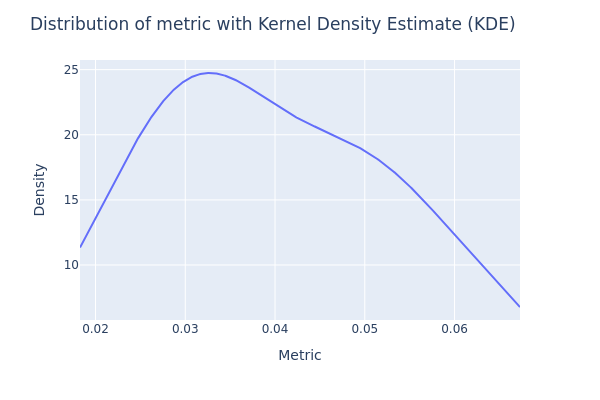

In [14]:
tracker.plot.kde(fig_type="png")

#### Reference Plot

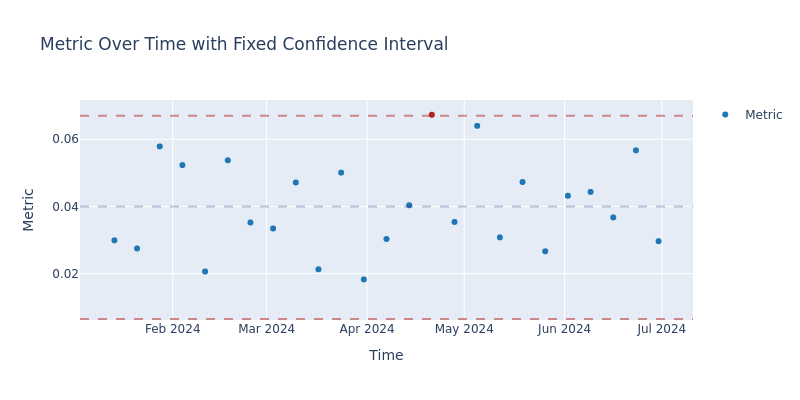

In [15]:
tracker.plot.scatter(tracker.reference_distance, fig_type="png")

In [16]:
chebyshev_guaranteed_percentage(tracker.reference_distance, [tracker.statistics["lower_limit"], tracker.statistics["upper_limit"]])

np.float64(0.7518073064311738)

#### Reference Analysis

In [17]:
df_grouped = df_test.groupby(pd.Grouper(key="datetime", freq="W"))["discrete_1"].apply(np.asarray)

In [18]:
analysis_score = tracker.score(df_grouped)

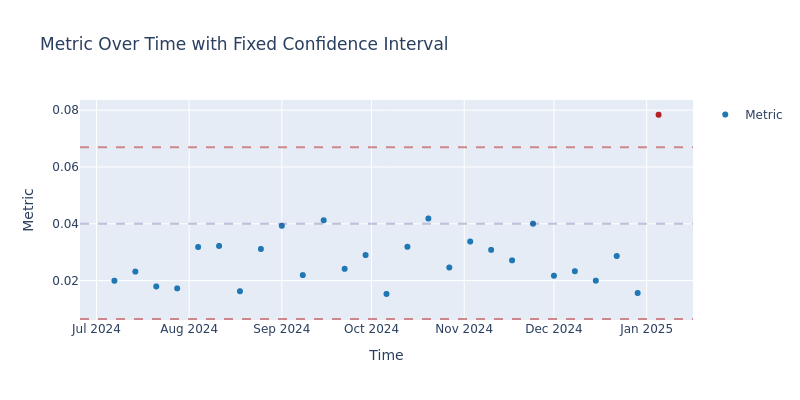

In [19]:
tracker.plot.scatter(analysis_score, fig_type="png")

### Interquartile Range (iqr)

In [20]:
df_grouped = df_reference.groupby(pd.Grouper(key="datetime", freq="W"))["discrete_0"].apply(np.asarray)
tracker = CategoricalDriftTracker(df_grouped, drift_limit="iqr", confidence_interval=True)

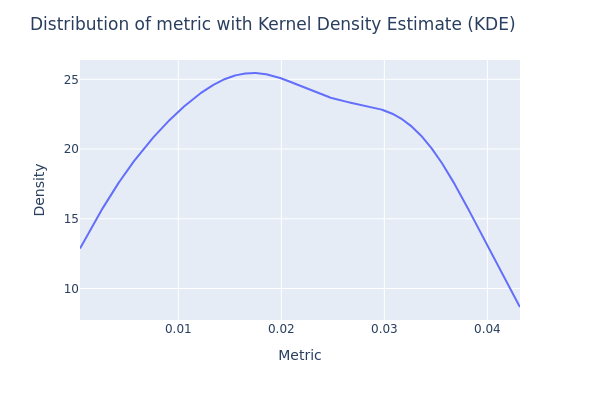

In [21]:
tracker.plot.kde(fig_type="png")

#### Reference Plot

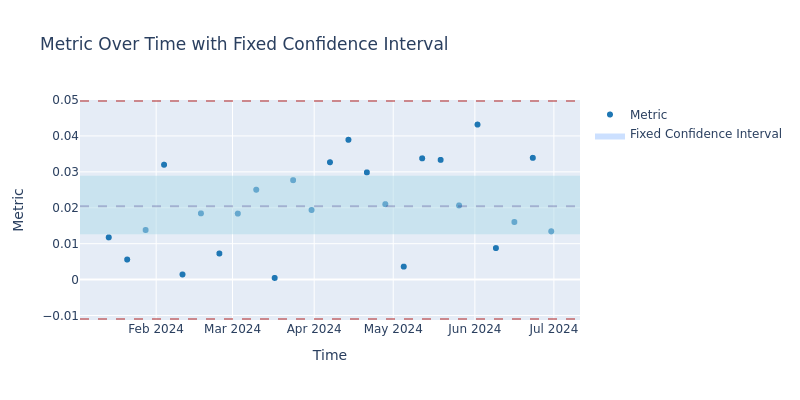

In [22]:
tracker.plot.scatter(tracker.reference_distance, fig_type="png")

In [23]:
chebyshev_guaranteed_percentage(tracker.reference_distance, [tracker.statistics["lower_limit"], tracker.statistics["upper_limit"]])

np.float64(0.8324482417113273)

#### Reference Analysis

In [24]:
df_grouped = df_test.groupby(pd.Grouper(key="datetime", freq="W"))["discrete_0"].apply(np.asarray)

In [25]:
analysis_score = tracker.score(df_grouped)

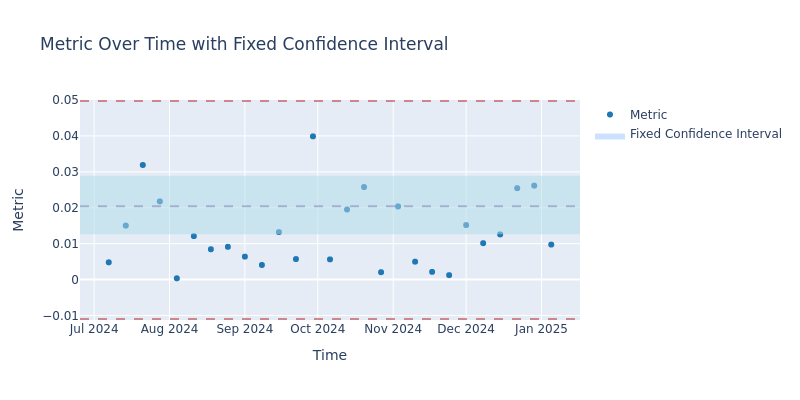

In [26]:
tracker.plot.scatter(analysis_score, fig_type="png")

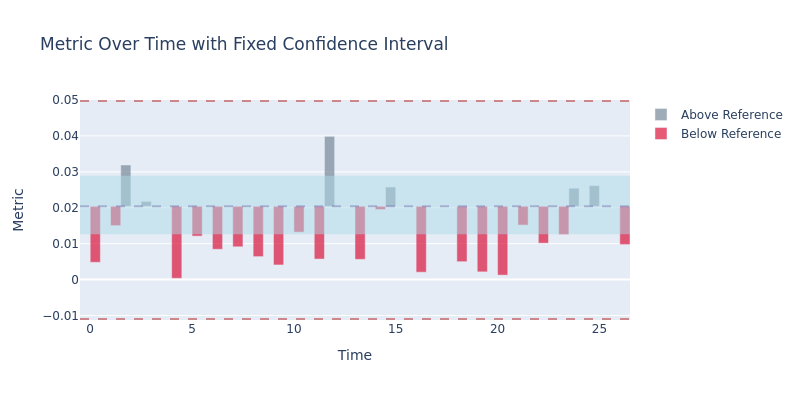

In [27]:
tracker.plot.bar(analysis_score, fig_type="png")

# Continuous Data Drift

## Wasserstein Distance

In [28]:
def percentile_threshold(data: pd.DataFrame):
    """Calculates thresholds using the 95th percentiles."""
    lower_limit = None
    upper_limit = np.percentile(data, 95, method="higher")
    return lower_limit, upper_limit

In [29]:
df_grouped = df_reference.groupby(pd.Grouper(key="datetime", freq="W"))["feature_1"].apply(np.asarray)
ws = ContinuousDriftTracker(df_grouped, func="ws", drift_limit=percentile_threshold, confidence_interval=True)

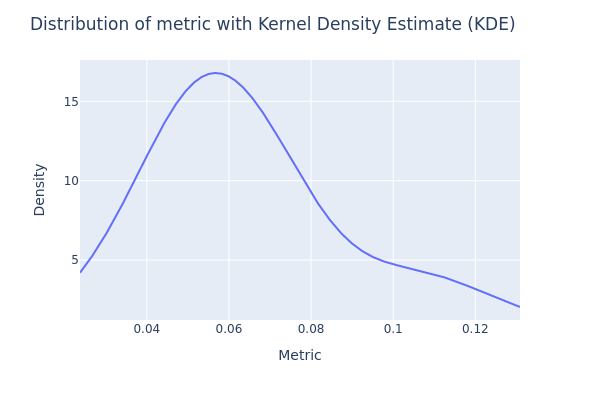

In [30]:
ws.plot.kde(fig_type="png")

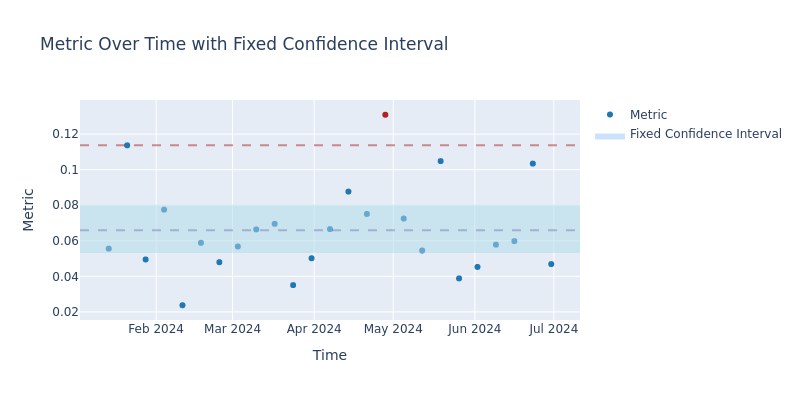

In [31]:
ws.plot.scatter(ws.reference_distance, fig_type="png")

In [32]:
chebyshev_guaranteed_percentage(ws.reference_distance, [ws.statistics["lower_limit"], ws.statistics["upper_limit"]])

np.float64(0.7236272139722689)

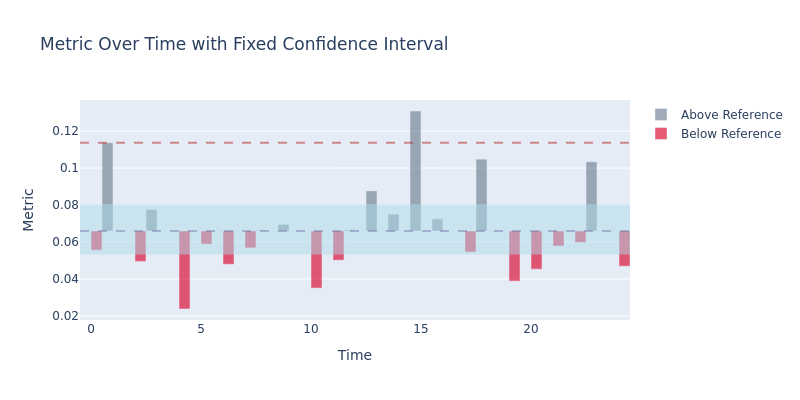

In [33]:
ws.plot.bar(ws.reference_distance, fig_type="png")

In [34]:
df_grouped = df_test.groupby(pd.Grouper(key="datetime", freq="W"))["feature_1"].apply(np.asarray)
test_ws = ws.score(df_grouped)

In [35]:
test_ws

datetime
2024-07-07    0.063965
2024-07-14    0.076502
2024-07-21    0.126251
2024-07-28    0.071962
2024-08-04    0.030056
2024-08-11    0.076564
2024-08-18    0.037549
2024-08-25    0.046158
2024-09-01    0.108532
2024-09-08    0.036845
2024-09-15    0.055631
2024-09-22    0.045467
2024-09-29    0.044207
2024-10-06    0.067408
2024-10-13    0.035273
2024-10-20    0.042981
2024-10-27    0.059560
2024-11-03    0.107839
2024-11-10    0.036393
2024-11-17    0.068190
2024-11-24    0.043507
2024-12-01    0.038054
2024-12-08    0.078988
2024-12-15    0.048737
2024-12-22    0.041122
2024-12-29    0.102998
2025-01-05    0.101197
Freq: W-SUN, Name: feature_1, dtype: float64

In [36]:
ws.predict(df_grouped)

datetime
2024-07-07    False
2024-07-14    False
2024-07-21     True
2024-07-28    False
2024-08-04    False
2024-08-11    False
2024-08-18    False
2024-08-25    False
2024-09-01    False
2024-09-08    False
2024-09-15    False
2024-09-22    False
2024-09-29    False
2024-10-06    False
2024-10-13    False
2024-10-20    False
2024-10-27    False
2024-11-03    False
2024-11-10    False
2024-11-17    False
2024-11-24    False
2024-12-01    False
2024-12-08    False
2024-12-15    False
2024-12-22    False
2024-12-29    False
2025-01-05    False
Freq: W-SUN, Name: feature_1, dtype: bool

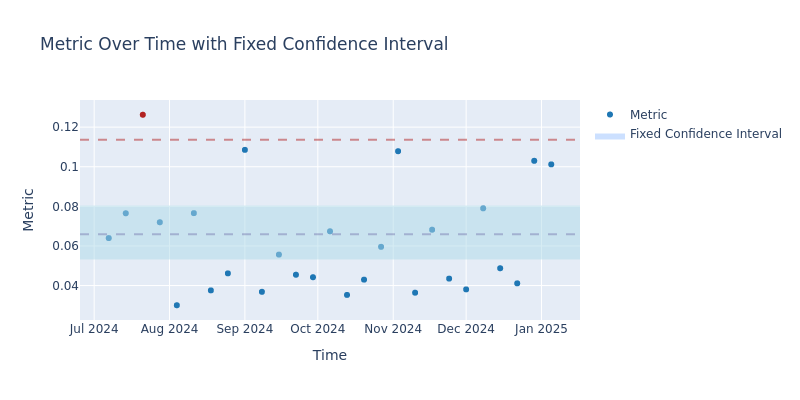

In [37]:
ws.plot.scatter(test_ws, fig_type="png")

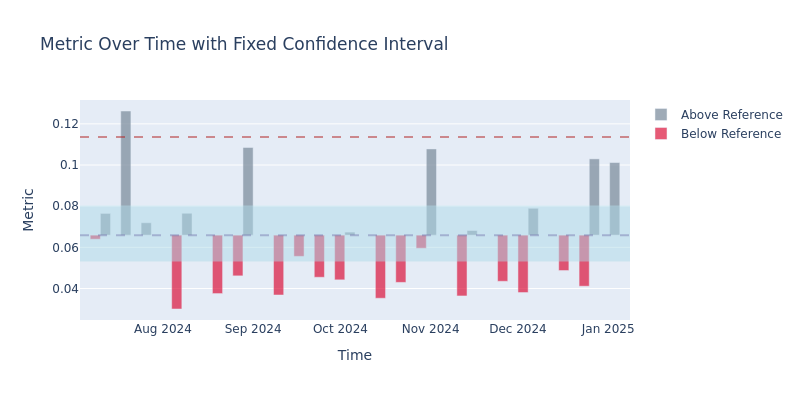

In [36]:
ws.plot.bar(test_ws, fig_type="png")

## Kolmogorov-Smirnov Test

In [37]:

ks = ContinuousDriftTracker(df_grouped, func="ks", drift_limit=(0.05, None), confidence_interval=True)

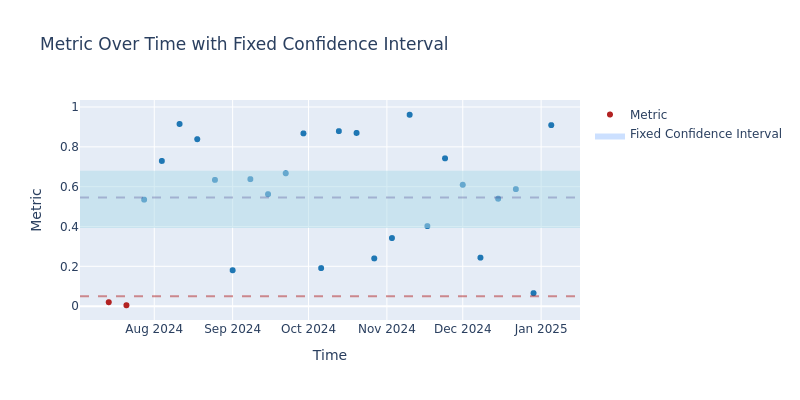

In [38]:
ks.plot.scatter(ks.reference_distance, fig_type="png")

In [39]:
chebyshev_guaranteed_percentage(ks.reference_distance["metric"], [ks.statistics["lower_limit"], 1])

np.float64(0.5795562133696539)

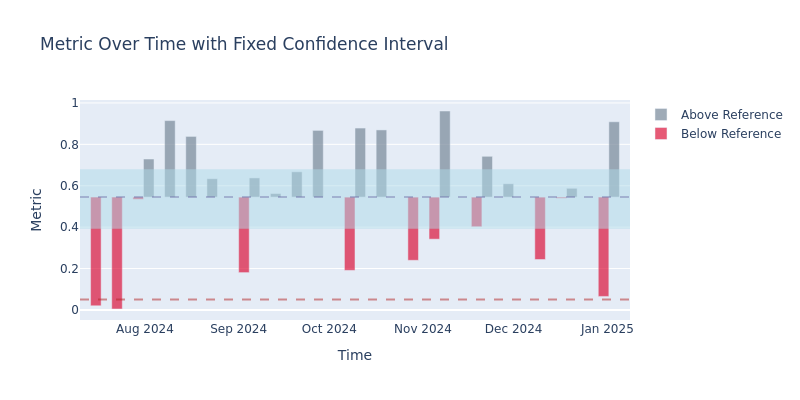

In [40]:
ks.plot.bar(ks.reference_distance, fig_type="png")

In [41]:
df_grouped = df_test.groupby(pd.Grouper(key="datetime", freq="W"))["feature_0"].apply(np.asarray)
test_ks = ks.score(df_grouped)

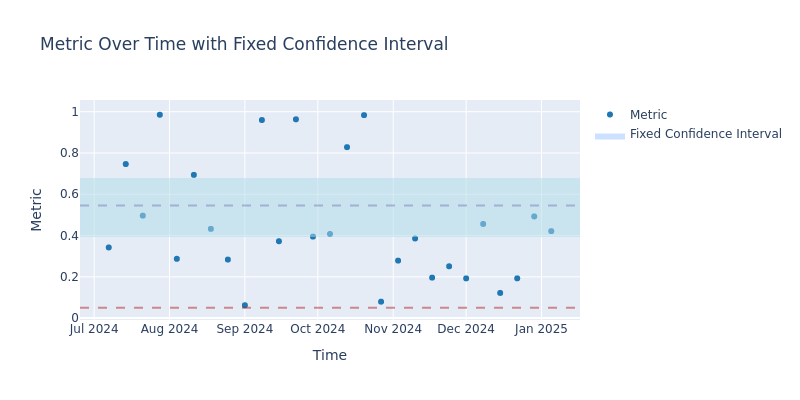

In [42]:
ks.plot.scatter(test_ks, fig_type="png")

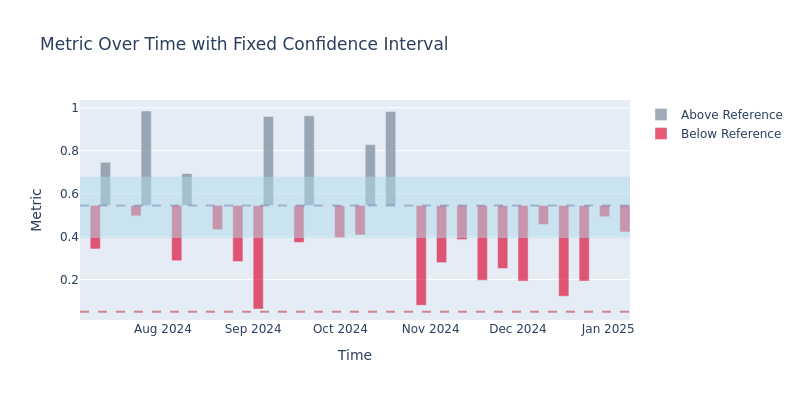

In [43]:
ks.plot.bar(test_ks, fig_type="png")

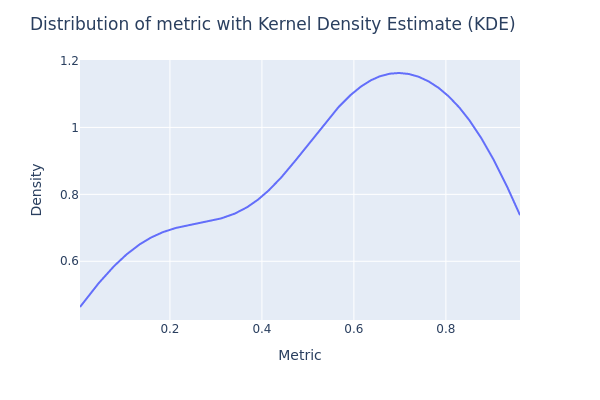

In [44]:
ks.plot.kde(fig_type="png")